In [1]:
!pip install python-box

In [2]:
import math 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import os


import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action = 'ignore')
torch.set_printoptions(sci_mode = True)

In [3]:
import pickle

In [4]:
os.getcwd()

'/Linux/Data/recommendation/vae_cf_pytorch'

In [5]:
config = {
    'data_path' : '/Linux/Data/recommendation/vae_cf_pytorch',
    'p_dims' : [200, 600],
    'dropout_rate' : 0.5,
    'weight_decay' : 0.01,
    'valid_samples' : 10,
    'seed' : 4141,
    'anneal_cap' : 0.2,
    'total_anneal_steps' : 200000,
    'lr' : 0.001,
    'batch_size' : 250,
    'num_epochs' : 100,
    'num_workers' : 2
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
config = Box(config)

In [8]:
pd.read_csv(os.path.join(config.data_path, 'ratings.csv'))

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


# 데이터 전처리

In [6]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'ratings.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['timestamp']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

In [7]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]
        
    def __len__(self):
        return self.num_user
    def __getitem__(self, idx):
        user = self.users[idx]
        return torch.LongTensor([user])

# 모델

## Multi-VAE

In [9]:
class MultiVAE(nn.Module):

    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]

        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])

        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        self.drop = nn.Dropout(dropout_rate)
        self.init_weights()
    
    def forward(self, input, loss = False):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        h = self.decode(z)
        if loss:
            return h, mu, logvar
        else:
            return h
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

## Multi-DAE

In [9]:
class MultiDAE(nn.Module):
    
    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]
        
        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
                                    d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout_rate)
        
        self.init_weights()
        
    def forward(self, input):
        h = F.normalize(input)
        h = self.drop(h)
        
        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h)
        return h
    
    def init_weights(self):
        for layer in self.layers:
            #Xavier initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0 / (fan_in + fan_out))
            layer.weight.data.normal_(0.0, 0.001)
        

# 학습함수

In [10]:
class LossFunc(nn.Module):

    def __init__(self, loss_type = 'Multinomial', model_type = None):
        super(LossFunc, self).__init__()
        self.loss_type = loss_type
        self.model_type = model_type

    def forward(self, recon_x = None, x = None, mu = None, logvar = None, anneal = None):
        if self.loss_type == 'Gaussian':
            loss = self.Gaussian(recon_x, x)
        elif self.loss_type == 'Logistic':
            loss = self.Logistic(recon_x, x)
        elif self.loss_type == 'Multinomial':
            loss = self.Multinomial(recon_x, x)
        
        if self.model_type == 'VAE':
            KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
            loss = loss + anneal * KLD
        
        return loss

    def Gaussian(self, recon_x, x):
        gaussian = F.mse_loss(recon_x, x)
        return gaussian

    def Logistic(self, recon_x, x):
        logistic = F.binary_cross_entropy(recon_x.sigmoid(), x, reduction='none').sum(1).mean()
        return logistic

    def Multinomial(self, recon_x, x):
        multinomial = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
        return multinomial

In [11]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit


def train(model, criterion, optimizer, data_loader, make_matrix_data_set, config):
    global update_count
    model.train()
    loss_val = 0
    for users in data_loader:
        mat = make_matrix_data_set.make_matrix(users)
        mat = mat.to(device)

        if criterion.model_type == 'VAE':
            anneal = min(config.anneal_cap, 1. * update_count / config.total_anneal_steps)
            update_count += 1
            recon_mat, mu, logvar = model(mat, loss = True)
            
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat, mu = mu, logvar = logvar, anneal = anneal)

        else:
            recon_mat = model(mat)
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, data_loader, user_train, user_valid, make_matrix_data_set):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    with torch.no_grad():
        for users in data_loader:
            mat = make_matrix_data_set.make_matrix(users)
            mat = mat.to(device)

            recon_mat = model(mat)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-10:].cpu().numpy().tolist()
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(data_loader.dataset)
    HIT /= len(data_loader.dataset)

    return NDCG, HIT

In [24]:
for users in data_loader:
    mat = make_matrix_data_set.make_matrix(users)
    mat = mat.to(device)
    print(mat)
    print(mat.sum())
    print(mat.shape)
    recon_mat = model(mat)
#    print(mat)
#    print(mat.type)
    print(recon_mat)
    print(recon_mat.shape)
    recon_mat[mat == 1] = -np.inf
    print(recon_mat)
    break
#     rec_list = recon_mat.argsort(dim = 1)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')
tensor(3.2867e+04, device='cuda:0')
torch.Size([250, 26744])
tensor([[-9.1745e-02, -1.1744e-01, 1.1096e-02,  ..., 3.6654e-02, 8.9754e-02, -1.4592e-01],
        [-1.7219e-01, 1.2064e-01, 3.9126e-02,  ..., -1.8942e-01, 2.9867e-01, 8.6999e-02],
        [-5.6484e-02, -2.4931e-01, 8.0742e-02,  ..., -1.1939e-02, 1.5015e-02, 2.7159e-02],
        ...,
        [-1.7544e-02, -5.3037e-02, -1.9379e-01,  ..., 8.5705e-02, -1.3339e-01, -1.5096e-

# 학습

In [12]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()

In [13]:
ae_dataset = AEDataSet(
        num_user = make_matrix_data_set.num_user)

In [14]:
data_loader = DataLoader(
    ae_dataset,
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [15]:
loss_dict = {}
ndcg_dict = {}
hit_dict = {}

## Multi-VAE

In [17]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [18]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Multinomial', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [18]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config.num_epochs + 1)):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1| Train loss: 1045.58067| NDCG@10: 0.18877| HIT@10: 0.16000
Epoch:   2| Train loss: 985.41026| NDCG@10: 0.22709| HIT@10: 0.19311
Epoch:   3| Train loss: 969.65505| NDCG@10: 0.24143| HIT@10: 0.20636
Epoch:   4| Train loss: 962.38074| NDCG@10: 0.24797| HIT@10: 0.21211
Epoch:   5| Train loss: 957.66504| NDCG@10: 0.25433| HIT@10: 0.21666
Epoch:   6| Train loss: 954.14794| NDCG@10: 0.25654| HIT@10: 0.21803
Epoch:   7| Train loss: 951.06014| NDCG@10: 0.26020| HIT@10: 0.22143
Epoch:   8| Train loss: 948.63420| NDCG@10: 0.25983| HIT@10: 0.22119
Epoch:   9| Train loss: 946.66553| NDCG@10: 0.26109| HIT@10: 0.22245
Epoch:  10| Train loss: 944.95847| NDCG@10: 0.26249| HIT@10: 0.22368
Epoch:  11| Train loss: 943.69879| NDCG@10: 0.26377| HIT@10: 0.22471
Epoch:  12| Train loss: 942.38938| NDCG@10: 0.26349| HIT@10: 0.22435
Epoch:  13| Train loss: 941.43091| NDCG@10: 0.26420| HIT@10: 0.22502
Epoch:  14| Train loss: 940.58335| NDCG@10: 0.26611| HIT@10: 0.22663
Epoch:  15| Train loss: 939.91843

In [19]:
loss_list_mvae = loss_list
ndcg_list_mvae = ndcg_list
hit_list_mvae = hit_list

In [20]:
loss_dict['Multi-VAE'] = loss_list
ndcg_dict['Multi-VAE'] = ndcg_list
hit_dict['Multi-VAE'] = hit_list

In [21]:
with open('multi_vae_loss.pkl', 'wb') as f:
    pickle.dump(loss_dict['Multi-VAE'], f)

In [22]:
with open('multi_vae_ndcg.pkl', 'wb') as f:
    pickle.dump(ndcg_dict['Multi-VAE'], f)

In [23]:
with open('multi_vae_hit.pkl', 'wb') as f:
    pickle.dump(hit_dict['Multi-VAE'], f)

## Gaussian-VAE

In [24]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Gaussian', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [25]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config.num_epochs + 1)):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1| Train loss: 0.00487| NDCG@10: 0.08615| HIT@10: 0.07501
Epoch:   2| Train loss: 0.00462| NDCG@10: 0.08768| HIT@10: 0.07610
Epoch:   3| Train loss: 0.00460| NDCG@10: 0.08809| HIT@10: 0.07621
Epoch:   4| Train loss: 0.00460| NDCG@10: 0.08781| HIT@10: 0.07603
Epoch:   5| Train loss: 0.00461| NDCG@10: 0.08790| HIT@10: 0.07598
Epoch:   6| Train loss: 0.00461| NDCG@10: 0.08733| HIT@10: 0.07573
Epoch:   7| Train loss: 0.00461| NDCG@10: 0.08811| HIT@10: 0.07618
Epoch:   8| Train loss: 0.00461| NDCG@10: 0.08799| HIT@10: 0.07616
Epoch:   9| Train loss: 0.00461| NDCG@10: 0.08757| HIT@10: 0.07564
Epoch:  10| Train loss: 0.00461| NDCG@10: 0.08793| HIT@10: 0.07610
Epoch:  11| Train loss: 0.00461| NDCG@10: 0.08790| HIT@10: 0.07609
Epoch:  12| Train loss: 0.00461| NDCG@10: 0.08737| HIT@10: 0.07561
Epoch:  13| Train loss: 0.00461| NDCG@10: 0.08798| HIT@10: 0.07609
Epoch:  14| Train loss: 0.00461| NDCG@10: 0.08757| HIT@10: 0.07591
Epoch:  15| Train loss: 0.00461| NDCG@10: 0.08762| HIT@10: 0.0

In [26]:
loss_dict['Gaussian-VAE'] = loss_list
ndcg_dict['Gaussian-VAE'] = ndcg_list
hit_dict['Gaussian-VAE'] = hit_list

In [27]:
with open('gaussian_vae_loss.pkl', 'wb') as f:
    pickle.dump(loss_dict['Gaussian-VAE'], f)

In [28]:
with open('gaussian_vae_ndcg.pkl', 'wb') as f:
    pickle.dump(ndcg_dict['Gaussian-VAE'], f)

In [29]:
with open('gaussian_vae_hit.pkl', 'wb') as f:
    pickle.dump(hit_dict['Gaussian-VAE'], f)

In [25]:
with open('gaussian_vae_loss.pkl', 'rb') as f:
    gaussian_vae_loss = pickle.load(f)

In [ ]:
with open('gaussian_vae_ndcg.pkl', 'rb') as f:
    gaussian_vae_ndcg = pickle.load(f)

In [ ]:
with open('gaussian_vae_hit.pkl', 'rb') as f:
    gaussian_vae_hit = pickle.load(f)

## Logistic-VAE

In [30]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Logistic', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [31]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config.num_epochs + 1)):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1| Train loss: 790.42972| NDCG@10: 0.12214| HIT@10: 0.10417
Epoch:   2| Train loss: 403.30696| NDCG@10: 0.15177| HIT@10: 0.12881
Epoch:   3| Train loss: 370.92623| NDCG@10: 0.18578| HIT@10: 0.15876
Epoch:   4| Train loss: 353.26436| NDCG@10: 0.20243| HIT@10: 0.17431
Epoch:   5| Train loss: 339.02530| NDCG@10: 0.21618| HIT@10: 0.18637
Epoch:   6| Train loss: 328.22006| NDCG@10: 0.22582| HIT@10: 0.19486
Epoch:   7| Train loss: 321.83400| NDCG@10: 0.23467| HIT@10: 0.20358
Epoch:   8| Train loss: 316.00818| NDCG@10: 0.24130| HIT@10: 0.20911
Epoch:   9| Train loss: 311.62557| NDCG@10: 0.24350| HIT@10: 0.21100
Epoch:  10| Train loss: 307.03094| NDCG@10: 0.24816| HIT@10: 0.21531
Epoch:  11| Train loss: 304.11903| NDCG@10: 0.25227| HIT@10: 0.21875
Epoch:  12| Train loss: 301.79265| NDCG@10: 0.23456| HIT@10: 0.20247
Epoch:  13| Train loss: 305.32815| NDCG@10: 0.25640| HIT@10: 0.22273
Epoch:  14| Train loss: 298.59362| NDCG@10: 0.25720| HIT@10: 0.22325
Epoch:  15| Train loss: 294.43281|

In [32]:
loss_dict['Logistic-VAE'] = loss_list
ndcg_dict['Logistic-VAE'] = ndcg_list
hit_dict['Logistic-VAE'] = hit_list

In [33]:
with open('logistic_vae_loss.pkl', 'wb') as f:
    pickle.dump(loss_dict['Logistic-VAE'], f)

In [34]:
with open('logistic_vae_ndcg.pkl', 'wb') as f:
    pickle.dump(ndcg_dict['Logistic-VAE'], f)

In [35]:
with open('logistic_vae_hit.pkl', 'wb') as f:
    pickle.dump(hit_dict['Logistic-VAE'], f)

## Multi-DAE

In [36]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Multinomial')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [37]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config.num_epochs + 1)):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1| Train loss: 1066.46377| NDCG@10: 0.15659| HIT@10: 0.13197
Epoch:   2| Train loss: 1020.61821| NDCG@10: 0.17389| HIT@10: 0.14677
Epoch:   3| Train loss: 1004.71776| NDCG@10: 0.19571| HIT@10: 0.16772
Epoch:   4| Train loss: 990.90532| NDCG@10: 0.21053| HIT@10: 0.17998
Epoch:   5| Train loss: 983.68643| NDCG@10: 0.21827| HIT@10: 0.18738
Epoch:   6| Train loss: 979.73423| NDCG@10: 0.22410| HIT@10: 0.19230
Epoch:   7| Train loss: 976.85187| NDCG@10: 0.23004| HIT@10: 0.19711
Epoch:   8| Train loss: 974.93514| NDCG@10: 0.23349| HIT@10: 0.19926
Epoch:   9| Train loss: 973.10570| NDCG@10: 0.23700| HIT@10: 0.20350
Epoch:  10| Train loss: 971.62022| NDCG@10: 0.23854| HIT@10: 0.20459
Epoch:  11| Train loss: 970.67490| NDCG@10: 0.23951| HIT@10: 0.20533
Epoch:  12| Train loss: 969.84494| NDCG@10: 0.23913| HIT@10: 0.20493
Epoch:  13| Train loss: 969.12057| NDCG@10: 0.24201| HIT@10: 0.20779
Epoch:  14| Train loss: 968.51875| NDCG@10: 0.24221| HIT@10: 0.20778
Epoch:  15| Train loss: 967.956

In [38]:
loss_dict['Multi-DAE'] = loss_list
ndcg_dict['Multi-DAE'] = ndcg_list
hit_dict['Multi-DAE'] = hit_list

In [39]:
with open('multi_dae_loss.pkl', 'wb') as f:
    pickle.dump(loss_dict['Multi-DAE'], f)

In [40]:
with open('multi_dae_ndcg.pkl', 'wb') as f:
    pickle.dump(ndcg_dict['Multi-DAE'], f)

In [41]:
with open('multi_dae_hit.pkl', 'wb') as f:
    pickle.dump(hit_dict['Multi-DAE'], f)

## Gaussian-DAE

In [42]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Gaussian')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [43]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config.num_epochs + 1)):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1| Train loss: 0.00503| NDCG@10: 0.08903| HIT@10: 0.07548
Epoch:   2| Train loss: 0.00502| NDCG@10: 0.08756| HIT@10: 0.07416
Epoch:   3| Train loss: 0.00502| NDCG@10: 0.08557| HIT@10: 0.07277
Epoch:   4| Train loss: 0.00502| NDCG@10: 0.08874| HIT@10: 0.07590
Epoch:   5| Train loss: 0.00502| NDCG@10: 0.08879| HIT@10: 0.07585
Epoch:   6| Train loss: 0.00502| NDCG@10: 0.08864| HIT@10: 0.07583
Epoch:   7| Train loss: 0.00502| NDCG@10: 0.08654| HIT@10: 0.07385
Epoch:   8| Train loss: 0.00502| NDCG@10: 0.08945| HIT@10: 0.07423
Epoch:   9| Train loss: 0.00502| NDCG@10: 0.08405| HIT@10: 0.07313
Epoch:  10| Train loss: 0.00502| NDCG@10: 0.08891| HIT@10: 0.07552
Epoch:  11| Train loss: 0.00502| NDCG@10: 0.08854| HIT@10: 0.07533
Epoch:  12| Train loss: 0.00502| NDCG@10: 0.08305| HIT@10: 0.07423
Epoch:  13| Train loss: 0.00502| NDCG@10: 0.08519| HIT@10: 0.07427
Epoch:  14| Train loss: 0.00502| NDCG@10: 0.09141| HIT@10: 0.07679
Epoch:  15| Train loss: 0.00502| NDCG@10: 0.08523| HIT@10: 0.0

In [44]:
loss_dict['Gaussian-DAE'] = loss_list
ndcg_dict['Gaussian-DAE'] = ndcg_list
hit_dict['Gaussian-DAE'] = hit_list

In [45]:
with open('gaussian_dae_loss.pkl', 'wb') as f:
    pickle.dump(loss_dict['Gaussian-DAE'], f)

In [46]:
with open('gaussian_dae_ndcg.pkl', 'wb') as f:
    pickle.dump(ndcg_dict['Gaussian-DAE'], f)

In [47]:
with open('gaussian_dae_hit.pkl', 'wb') as f:
    pickle.dump(hit_dict['Gaussian-DAE'], f)

## Logistic-DAE

In [48]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Logistic')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [49]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config.num_epochs + 1)):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1| Train loss: 839.84829| NDCG@10: 0.09118| HIT@10: 0.07850
Epoch:   2| Train loss: 457.56400| NDCG@10: 0.10306| HIT@10: 0.08759
Epoch:   3| Train loss: 449.38796| NDCG@10: 0.10606| HIT@10: 0.09223
Epoch:   4| Train loss: 442.41805| NDCG@10: 0.12640| HIT@10: 0.10880
Epoch:   5| Train loss: 424.27450| NDCG@10: 0.13310| HIT@10: 0.11342
Epoch:   6| Train loss: 417.40529| NDCG@10: 0.13450| HIT@10: 0.11355
Epoch:   7| Train loss: 412.10077| NDCG@10: 0.14766| HIT@10: 0.12449
Epoch:   8| Train loss: 406.58616| NDCG@10: 0.15945| HIT@10: 0.13509
Epoch:   9| Train loss: 401.61956| NDCG@10: 0.16200| HIT@10: 0.13761
Epoch:  10| Train loss: 397.67838| NDCG@10: 0.16746| HIT@10: 0.14027
Epoch:  11| Train loss: 391.83955| NDCG@10: 0.17239| HIT@10: 0.14629
Epoch:  12| Train loss: 382.82878| NDCG@10: 0.18333| HIT@10: 0.15745
Epoch:  13| Train loss: 373.52380| NDCG@10: 0.18681| HIT@10: 0.16007
Epoch:  14| Train loss: 364.17325| NDCG@10: 0.19535| HIT@10: 0.16794
Epoch:  15| Train loss: 357.23528|

In [50]:
loss_dict['Logistic-DAE'] = loss_list
ndcg_dict['Logistic-DAE'] = ndcg_list
hit_dict['Logistic-DAE'] = hit_list

In [51]:
with open('logistic_dae_loss.pkl', 'wb') as f:
    pickle.dump(loss_dict['Logistic-DAE'], f)

In [52]:
with open('logistic_dae_ndcg.pkl', 'wb') as f:
    pickle.dump(ndcg_dict['Logistic-DAE'], f)

In [53]:
with open('logistic_dae_hit.pkl', 'wb') as f:
    pickle.dump(hit_dict['Logistic-DAE'], f)

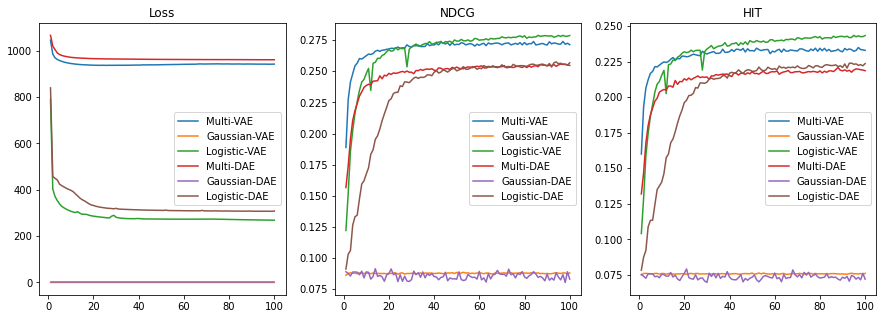

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

for k in loss_dict.keys():
    ax[0].plot(epochs, loss_dict[k], label = k)
ax[0].set_title('Loss')
ax[0].legend()

for k in ndcg_dict.keys():
    ax[1].plot(epochs, ndcg_dict[k], label = k)
ax[1].set_title('NDCG')
ax[1].legend()

for k in hit_dict.keys():
    ax[2].plot(epochs, hit_dict[k], label = k)
ax[2].set_title('HIT')
ax[2].legend()
plt.show()